# Distance Metrics and Clustering

This tutorial introduces the use of distance metrics and their use in analytics and unsupervised machine learning. We will first define a few distance metrics, their application in analytics, and then implement them in a clusering algorithm. This tutorial builds off of the [web scraping](https://www.placedata.net/posts/web-scraping/) post by using the data collected from Google maps to generate clusters of New York city zip codes.

<br>

<img src="https://cmry.github.io/sources/eucos.png" width="250px">

<br>

### Distance Metrics

Architects and professions dealing with the built environment are very familiar with the concept of distance – particularly Euclidean distance. Distance, as defined by Wikipedia, *is a numerical measurement of how far apart objects or points are.* But the *metric* use to measure distance can change depending on the context. For example, many machine learning and statistical models use various distance metrics to fit a model to data, and thus *learn* any inherent patterns. The metrics you use to measure how the data fits to the model can determine how robust or fragile the model is to new data points. When dealing with physical space we are most used to thinking of distance in terms of Euclidean space, which is the shortest path between points. You may remember the formula from high school mathematics:

<br>

$ Distance = \sqrt{(x2 - x1)^{2} + (y2 - y1)^{2}} $

<br>

Euclidean distance is used in some regression and clustering algorithms like [K-means](https://en.wikipedia.org/wiki/K-means_clustering), to measure the *similarity* between points. 


Another metric often used in statistical modelling is **Manhattan** distance. Manhattan distance can be thought of visually as measuring distance in a grid like structure – as such it is also known as taxicab or city block distance. Instead of taking the shortest path between points, Manhattan distance takes the sum of absolute distances across all dimensions (e.g. the *X* or *Y* axis).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Manhattan_distance.svg/1024px-Manhattan_distance.svg.png" width="250px">

Manhattan distance is also used in regression, but might be chosen over Euclidean distance when you want to build a model that is robust to outliers and are OK with your results having some large errors.

The final metric to highlight before we dive into Python is **Cosine** distance. Cosine distance differs from the previous two, in that instead of measuring the magnitude (Euclidean space) between vectors, it measures the angle between / directionality of vectors. It is useful for instances when you want to measure the similarity between entities and where the magnitude of the things does not matter.


<br>
<br>

### Measuring Similarity in NYC Neighborhoods

Now that we have laid out some context around the definition and use of distance metrics, let's now apply these to measure the similairty between NYC neighborhoods using retail data scraped from Google maps. To do this let's begin by downloading the appropriate Python libraries:

In [98]:
import geopandas as gpd
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans

<br>

Next we can load the scraped data from Google and US zip code geometries.

In [188]:
poi = gpd.read_file('nyc_poi.geojson')

In [189]:
print(poi.shape)
poi.head(1)

(7324, 12)


,name,rating,num_revs,cost,tags,address,description,county,complete,lat,lng,geometry
0,Shabu Shabu Mayumon,4.9,(34),None,Shabu Shabu,115 Division St,Shabu-shabu omakase counter,new york,115 Division St new york,40.71434,-73.99205,POINT (-73.99205 40.71434)


In [190]:
zips.head(1)

,region_id,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,53922,53922,53922,B5,G6350,S,118603010,1919478,43.52093,-88.715147,"POLYGON ((-88.79170 43.53140, -88.79127 43.531..."


<br>

In order to cluster NYC neighborhoods based on retail establishments, we will first have to assign neighborhoods (zip codes) to retail points. Below we merge the two datasets using a GeoPandas spatial join.

In [6]:
path = '/Users/carlo/Downloads/geo_data 2/us_zipcodes.geojson'
zips = gpd.read_file(path)

In [191]:
combined = gpd.sjoin(zips, poi, op='contains')

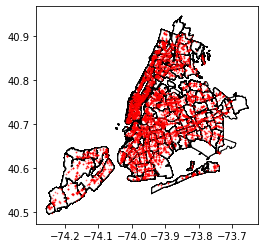

In [196]:
ax = combined.plot(color='white', edgecolor='black')
poi.plot(ax=ax, marker='o', color='red', alpha=0.5, markersize=0.5);

<br>
<br>

Now that we have the merged data, the next step is to construct vectors of retailers for every zip code in NYC. A vector in this context can be thought of as a long sequence that indicates the occurences of every restaurant *type* in a given zip code. For example, a neighborhood like Williamsburg might have a vector that includes: 5 Mexican restaurants, 10 Chinese restaurants, 25 pizza places... etc. And we can then use this vectors to compare between neighborhoods.

The below code constructs the vectors by grouping the data by the resturant tags / types and counts the occurences of each in every zip code.

In [148]:
temp = combined.groupby('tags').filter(lambda x: len(x) >= 2)
temp = temp.groupby('tags')['region_id'].value_counts().rename('counts').reset_index()

In [149]:
vec = pd.pivot_table(temp, columns='tags', 
                     index='region_id', 
                     values='counts').fillna(0)

<br>

Now that we have vectors for every zip code, we can then use cosine distance to measure similarity between neighborhoods.

In [150]:
sim = cosine_distances(vec)
sim = pd.DataFrame(data=sim, index=vec.index,
                   columns=vec.index)

In [151]:
sim['10011'].sort_values()[:10]

region_id
10011    0.000000
10013    0.119436
10014    0.133533
10019    0.136250
10023    0.169568
10024    0.221715
10003    0.225029
10005    0.241301
10006    0.244851
10002    0.255507
Name: 10011, dtype: float64

<br>
<br>

# K-Means Clustering

Finally, with our vectors of restaurant types in each zip code, we can use K-means clustering to group neighborhoods based on their restaurant composition. K-means clustering is a way to group or partition datapoints into distinct clusters based on the distance between datapoints across a number of dimensions. Sklearn has an out-of-the-box algorithm we can use to do this. The algorithm takes as an input the number of cluster you wish to generate. For this demo we will choose 5 clusters.

After clustering we then label our inital vec dataframe with the cluster numbers they've been assigned, and then merge this back with our zip code geometry to visualize in GeoPandas.

In [152]:
km = KMeans(5, random_state=42).fit(vec)
temp = vec.copy()
temp['labels'] = km.labels_

In [153]:
temp = temp[['labels']]

<AxesSubplot:>

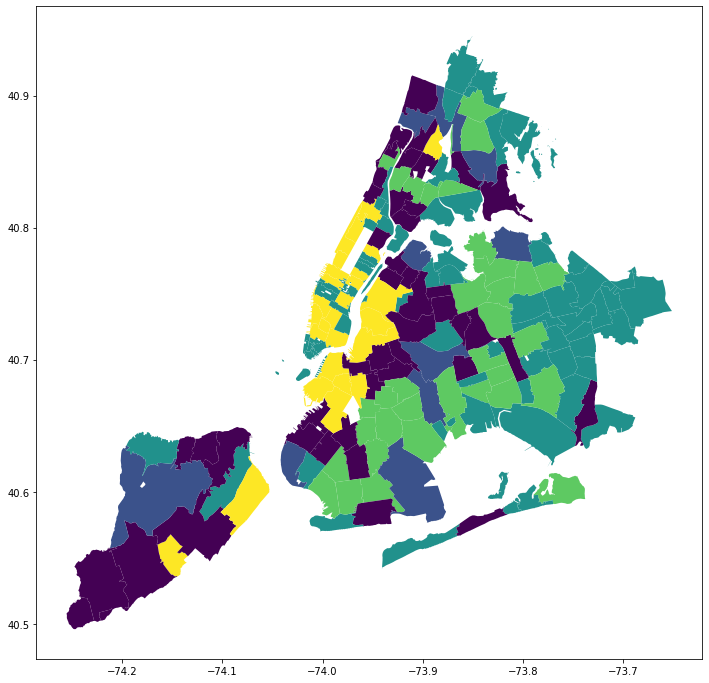

In [154]:
temp1 = zips.merge(temp, left_on='region_id', right_index=True)
temp1[~temp1['region_id'].str.startswith('07')].plot(column='labels', figsize=(12,12))

<AxesSubplot:>

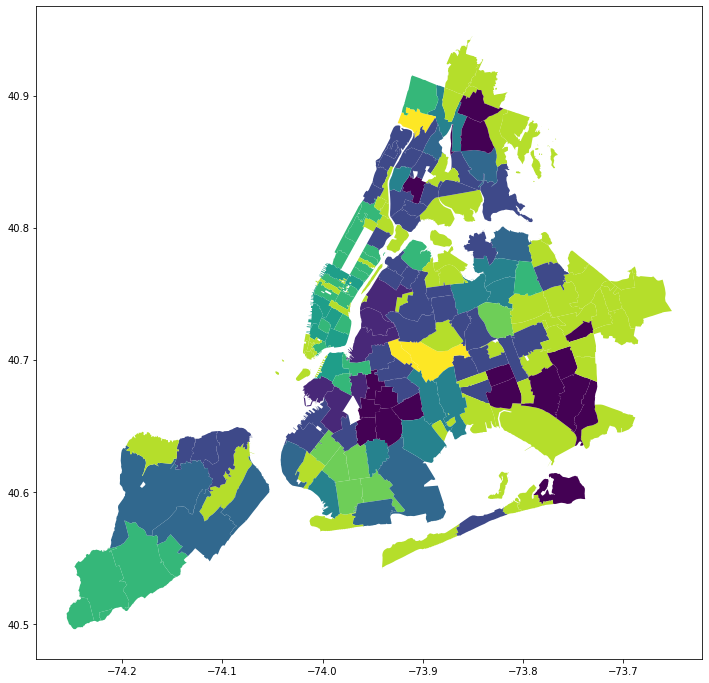

In [156]:
km = KMeans(10, random_state=42).fit(vec)
temp = vec.copy()
temp['labels'] = km.labels_

temp = temp[['labels']]

temp1 = zips.merge(temp, left_on='region_id', right_index=True)
temp1[~temp1['region_id'].str.startswith('07')].plot(column='labels', figsize=(12,12))